In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from datetime import datetime
import pickle
import json
# from pyomo.util.infeasible import log_infeasible_constraints
# import logging
#
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.preprocessing import StandardScaler


In [30]:
# Basic Setting
grid = "369_0"
this_day = '2050-05-06'
this_weekday = 'Friday'
next_two = True # True consider next 2 trips,False consider only next 1 trip
date = 6
scenario_year = 2050
day_start = pd.to_datetime(f"{scenario_year}-05-{date}")
day_end = pd.to_datetime(f"{scenario_year}-05-{date+1}")
path = f"{grid}/split_v5_{scenario_year}_2tripvarypower"

In [31]:
# Data Preprocessing
def create_dict(row):
    dict = [0]*24
    for hour in range(24):
        if (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']==hour): 
            dict[hour] = 60-row['arr_time'].minute
        elif  (row['park_end_day']>date) & (row['arr_hour']==hour)&(row['arr_time'].day==date):
            dict[hour] = 60-row['arr_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']<hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_time'].day<date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']==hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute-row['arr_time'].minute
        else:
            dict[hour]=0
    return dict

def soe_init(row):
    soe_init=[0]*24
    for hour in range(24):
        if row['arr_time'].day<date:
            soe_init[hour] = row['SoE_bc']
        elif (hour<=row["arr_hour"]) and (row['arr_time'].day==date):
            soe_init[hour]=row['SoE_bc']
        else:
            soe_init[hour]=0
    return soe_init

def create_charge_time_list(row):
    charge_time_list = [0]*24
    if row['c']:
        st_chg = row['st_chg_time'].hour
        ed_chg = row['ed_chg_time'].hour
        for t in range(24):
            if (st_chg==t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute-row['st_chg_time'].minute
            elif (st_chg<t) & (ed_chg>t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = 60
            elif (st_chg<t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute
            elif (st_chg==t) & (((ed_chg>t) & (row['ed_chg_time'].day == date))|(row['ed_chg_time'].day>date)):
                charge_time_list[t] = 60-row['st_chg_time'].minute
            elif (st_chg<t) & (row['ed_chg_time'].day>date):
                charge_time_list[t]=60
            else:
                charge_time_list[t]=0
    return charge_time_list

# Data Postprocessing
def get_timestamp_pair(row):
    process = {}
    process_key = ()
    power = []
    for hour in range(24):
        p_t = row['optimized_power_list'][hour]
        min_t = row['hourly_time_dict'][hour]
        if hour>0:
            min_pre, p_pre = row['hourly_time_dict'][hour-1],row['optimized_power_list'][hour-1]
        else: 
            min_pre,p_pre = 0,0
        if hour<23:
            min_next, p_next = row['hourly_time_dict'][hour+1],row['optimized_power_list'][hour+1]
        else:
            min_next, p_next = 0,0
        if p_pre==0 and p_t!=0:
            if (min_t == 60 or min_pre==60) and (hour!=row['arr_time'].hour):
                start_min = 0
            elif (min_t<60 and min_pre!=60 and min_t>0) and (hour!=row['arr_time'].hour):
                start_min = 60-min_t
            elif (hour==row['arr_time'].hour):
                start_min = row['arr_time'].minute
            else:
                start_min = 0
            start_ts = pd.Timestamp(datetime(year=scenario_year,month=5,day=date,hour=hour,minute=start_min))
            process_key = (start_ts,)
        if p_t!=0:
            power.append(p_t)
        if p_next==0 and p_t!=0:
            if (min_t==60 or min_next>0) and (hour!=row['park_end_time'].hour):
                end_min=59
            elif (min_t<60 and min_next==0 and min_pre>0) and (hour!=row['park_end_time'].hour):
                end_min=min_t
            elif (hour==row['park_end_time'].hour):
                end_min=row['park_end_time'].minute
            else:
                end_min = 0
            end_ts = pd.Timestamp(datetime(year=scenario_year,month=5,day=date,hour=hour,minute=end_min))
            process_key = process_key + (end_ts,)
            process[process_key] = power
            process_key = ()
            power = []
    return process

def calculate_next_trip_e(row):
    if next_two and (row['next_parking_time']<60):
        next_trip_e = row['next_travel_TP1_consumption']+row['next_2_travel_TP1_consumption']
    else:
        next_trip_e =  row['next_travel_TP1_consumption']
    return next_trip_e
        

In [32]:
df = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid369_mobility_dataset.csv")
df['dep_time'] = pd.to_datetime(df['dep_time'],format='mixed')
df['arr_time'] = pd.to_datetime(df['arr_time'],format='mixed')
df['st_chg_time'] = pd.to_datetime(df['st_chg_time'],format='mixed')
df['ed_chg_time'] = pd.to_datetime(df['ed_chg_time'],format='mixed')
df['chg_time'] = pd.to_timedelta(df['ed_chg_time']-df['st_chg_time'],unit='m')
df['dep_hour'] = df['dep_time'].dt.hour
df['arr_hour'] = df['arr_time'].dt.hour
df.sort_values(by=['person','dep_time'])
df['next_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)
df['next_parking_time'] = df.groupby('person')['parking_time'].shift(-1).fillna(0)
df['next_2_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-2).fillna(0)
df['next_trip_e'] = df.apply(calculate_next_trip_e,axis=1)
df.drop(['next_parking_time','next_travel_TP1_consumption','next_2_travel_TP1_consumption'], axis=1,inplace=True)

In [33]:
d = df[(df['grid'] == "369_0") & ((df['type_day'] == 'Thursday') | (df['type_day'] == 'Friday'))]
d['arr_time'] = d['dep_time'] + pd.to_timedelta(d['trav_time'], unit='m')
d.loc[d['type_day'] == 'Friday', 'arr_time'] = d.loc[d['type_day'] == 'Friday', 'arr_time'].apply(lambda dt: dt.replace(day=date, month=5, year=scenario_year))
d.loc[d['type_day'] == 'Thursday', 'arr_time'] = d.loc[d['type_day'] == 'Thursday', 'arr_time'].apply(lambda dt: dt.replace(day=date-1, month=5, year=scenario_year))
d['park_end_time'] = d['arr_time']+pd.to_timedelta(d['parking_time'],unit='m')
d['park_end_hour'] = d['park_end_time'].dt.hour
d['park_end_day'] = d['park_end_time'].dt.day
d.loc[:, 'st_chg_time'] = d.apply(lambda row: row['st_chg_time'].replace(day=row['arr_time'].day, month=row['arr_time'].month, year=row['arr_time'].year), axis=1)
d['ed_chg_time'] = d['st_chg_time']+d['chg_time']
d['chg_time'] = d['chg_time'].dt.total_seconds()/60
d = d[(d['park_end_time']>=day_start) & (d['arr_time']<day_end)]
d.insert(0,'event_index',d.index)
d['max_chg_e'] = d['B']-d['SoE_bc']
d['real_chg_e'] = d['SoE_ac']-d['SoE_bc']
d['hourly_time_dict'] = d.apply(lambda x:create_dict(x), axis =1)
d['soe_init'] = d.apply(lambda x:soe_init(x), axis =1)
d['charge_time_list'] = d.apply(lambda x:create_charge_time_list(x), axis=1)
d['charge_power_list'] = d.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
d['charge_energy_list'] = d.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2189627121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['arr_time'] = d['dep_time'] + pd.to_timedelta(d['trav_time'], unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2189627121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['park_end_time'] = d['arr_time']+pd.to_timedelta(d['parking_time'],unit='m')
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2189627121.py:6: SettingWithCopyWarnin

In [34]:
# Normalize Tobia's Nexus Output
hv_bus = str(89)
# Controlled charging
charge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/Added_up_charge_{scenario_year}_raw.csv") # in MW
# charge.rename(columns={'Unnamed: 0':'ts'}, inplace=True)
charge['ts'] = pd.to_datetime(charge['ts'])
charge = charge.loc[(charge.ts<day_end) & (charge.ts>=day_start)][['ts','peak',hv_bus]]
# Controlled discharging
discharge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/EVBatt_power_hourly_{scenario_year}_discharge_mapped.csv")
discharge = discharge.rename(columns={'Unnamed: 0':'ts'})
discharge['ts'] = pd.to_datetime(discharge['ts'])
discharge = discharge.loc[(discharge.ts<day_end) & (discharge.ts>=day_start)][['ts',hv_bus]]
# Find Netload Max
net= charge['89']-discharge['89']
day_max = net.max()
charge['normalized_profile'] = charge[hv_bus]/day_max
charge.index=range(24)
discharge['normalized_profile'] = discharge[hv_bus]/day_max
discharge.index=range(24)
net = charge['89']-discharge['89']
net_normalized = net/day_max

In [35]:
clustered = d.sort_values(by=['arr_time','parking_time'])
k = 20
group = np.arange(len(clustered)) % k
clustered['cluster']=group

In [36]:
def opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,date,cluster_i,path):
    t_list = list(range(24))
    e_list = list(cluster.event_index)
    tomatch_c = charge['normalized_profile']
    tomatch_d = discharge['normalized_profile']
    tomatch_net = net_normalized
    event_cnt = len(cluster)
    
    m = ConcreteModel()
    ############################
    # Set
    m.E = Set(initialize=e_list) # parking event set
    m.T = Set(initialize=t_list) # hour of the day
    ############################
    # Decision Variable
    m.charge_power = Var(m.E, m.T,within=NonNegativeReals,bounds=(0,1.5),initialize=0) 
    m.discharge_power = Var(m.E,m.T,within=NonNegativeReals,bounds=(0,1),initialize=0)
    
    m.is_parked = Var(m.E, m.T, within=Binary)
    m.is_charging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_discharging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_active = Var(m.E,within=Binary,initialize=0)
    m.charge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect charge jump
    m.discharge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect discharge jump

    
    # Slack Variable
    m.charge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals,initialize=0)
    m.discharge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals, initialize=0)
    m.energy_surplus = Var(within=NonNegativeReals,bounds=(0,0.1*normalized_tot_e))
    m.energy_deficit = Var(within=NonNegativeReals,bounds=(0,0.1*normalized_tot_e))
    
    # Auxiliary Variable
    m.tot_charge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    m.tot_discharge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    ###########################
    # Parameters
    m.event_cnt = Param(initialize=event_cnt)
    
    load_c = {t:tomatch_c[t] for t in t_list}
    m.charge_to_match = Param(m.T,initialize=load_c) # Normalized nexus profile
    
    load_d = {t:tomatch_d[t] for t in t_list}
    m.discharge_to_match = Param(m.T,initialize=load_d) # Normalized nexus profile
    
    load_net = {t:tomatch_net[t] for t in t_list}
    m.netload_to_match = Param(m.T,initialize=load_net) # Normalized net charge nexus profile
    
    capacity = {e:cluster.loc[e,'B']/emob_max_p for e in e_list}
    m.capacity = Param(m.E,initialize=capacity) # Normalized battery capacity
    
    max_power_dict = {e:cluster.loc[e,'normalized_chg_power'] for e in e_list} # max charge rate at normalized scale
    m.max_power = Param(m.E,initialize=max_power_dict) # unit kW

    parking_duration = {e:cluster.loc[e,'parking_time'] for e in e_list}
    m.parking_durat = Param(m.E,initialize=parking_duration) # parking time in minutes
    
    parking_time_dict = {(e,t):cluster.loc[e,'hourly_time_dict'][t]/60 for e in e_list for t in t_list}
    m.parking_time = Param(m.E,m.T,initialize=parking_time_dict) # parking minutes within this hour
    
    next_trip_e_dict = {e:cluster.loc[e,'next_trip_e']/emob_max_p for e in e_list}
    m.next_trip_e = Param(m.E,initialize=next_trip_e_dict) # normalized energy next trip requires
    
    park_end_hour_dict = {e:cluster.loc[e,'park_end_hour'] for e in e_list}
    m.park_end_hour = Param(m.E,initialize=park_end_hour_dict) # Park End Hour
    
    park_end_day = {e:cluster.loc[e,'park_end_day'] for e in e_list}
    m.park_end_day = Param(m.E, initialize=park_end_day)# Park End Day
    
    arr_day = {e:cluster.loc[e,'arr_time'].day for e in e_list}
    m.arr_day = Param(m.E,initialize=arr_day)
    
    arr_hour = {e:cluster.loc[e,'arr_hour'] for e in e_list}
    m.arr_hour = Param(m.E, initialize=arr_hour)
    
    SoE_dict = {(e,t):cluster.loc[e,'soe_init'][t]/emob_max_p for e in e_list for t in t_list}
    m.SoE_2d = Param(m.E,m.T,initialize=SoE_dict) # initial SoE profile
    
    SoE_init= {e:cluster.loc[e,'SoE_bc']/emob_max_p for e in e_list}
    m.SoE_init = Param(m.E,initialize=SoE_init) # initial SoE profile
    
    max_chg_e_dict = {e:cluster.loc[e,'max_chg_e']/emob_max_p for e in e_list}
    m.max_chg_e = Param(m.E,initialize=max_chg_e_dict) # max energy to charge for each event 
    
    m.unshifted_daily_energy = Param(initialize=normalized_tot_e)
    
    charge_status_change = {e:0 for e in e_list}
    m.charge_status_change = Param(m.E, initialize=charge_status_change) 
    
    ############################
    # enforce is_charging=1 if charging, 0 if discharging/no action
    def positive_charge_power_rule_1(m, e, t):
        return m.charge_power[e, t] <= 1000000 * m.is_charging[e, t]
    m.positive_charge_power_con = Constraint(m.E, m.T, rule=positive_charge_power_rule_1)

    # enforce is_discharging=1 if discharging, 0 if charging/no action
    def negative_charge_power_rule(m, e, t):
        return m.discharge_power[e, t] <= 1000000 * m.is_discharging[e, t]
    m.negative_charge_power_con = Constraint(m.E, m.T, rule=negative_charge_power_rule)
    # avoid simultaneous charge and discharge
    def non_simultaneous_rule(m, e, t):
        return m.is_charging[e, t] + m.is_discharging[e, t] <= 1
    m.non_simultaneous_con = Constraint(m.E, m.T, rule=non_simultaneous_rule)
    # enforce is_parked=1 if parking and ready to participate in grid, 0 if not available
    def parking_logic_constraint(m, e, t):
        M = 1000000  # Big M value, adjust as necessary
        return m.parking_time[e, t] <= M * m.is_parked[e, t]
    m.parking_logic = Constraint(m.E, m.T, rule=parking_logic_constraint)

    '''
    charging power limit
    '''
    # charge/discharge power slightly deviate from max charge power
    def charge_power_limit_rule(m,e,t):
        return  m.charge_power[e, t]  <= m.max_power[e] * m.is_charging[e,t] # + m.charge_power_limit_s[e,t]
    m.power_limit_c = Constraint(m.E, m.T, rule=charge_power_limit_rule)
    def discharge_power_limit_rule(m,e,t):
        return  m.discharge_power[e, t] <= m.max_power[e] * m.is_discharging[e,t] # + m.discharge_power_limit_s[e,t]
    m.power_limit_d = Constraint(m.E, m.T, rule=discharge_power_limit_rule)
    
    def charge_power_limit_s_upper_rule(m, e, t):
        return m.charge_power[e, t] >= 0.7 * m.max_power[e]*m.is_charging[e,t]
    m.charge_power_limit_s_upper = Constraint(m.E, m.T, rule=charge_power_limit_s_upper_rule)

    def discharge_power_limit_s_upper_rule(m, e, t):
        return m.discharge_power[e, t] >= 0.7 * m.max_power[e]*m.is_discharging[e,t]
    m.discharge_power_limit_s_upper = Constraint(m.E, m.T, rule=discharge_power_limit_s_upper_rule)
    
    def decreasing_charge_rule(m,e,t):
        if t>=m.arr_hour[e] and t<23:
            return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_charge = Constraint(m.E,m.T,rule=decreasing_charge_rule)
    def decreasing_discharge_rule(m,e,t):
        if t>=m.arr_hour[e] and t<23:
            return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_discharge = Constraint(m.E,m.T,rule=decreasing_discharge_rule)
    
    def parking_rule_c(m,e,t):
        if m.parking_time[e,t]==0: 
            return m.charge_power[e,t]==0 # not parked for charge
        elif t<23 and m.parking_time[e,t]<float(0.25/3) and m.parking_time[e,t+1]==0:
            return m.charge_power[e,t]==0 # do not charge in the last parking hour less than 5 min
        else:
            return Constraint.Skip
    m.parking_c = Constraint(m.E,m.T,rule=parking_rule_c)   
    def parking_rule_d(m,e,t):
        if m.parking_time[e,t]==0:
            return m.discharge_power[e,t]==0 # not parked for discharge
        else:
            return Constraint.Skip
    m.parking_d = Constraint(m.E,m.T,rule=parking_rule_d)  
    
    # Plug in as soon as parked
    # def charge_immediate_rule(m,e,t):
    #     if (t>m.arr_hour[e]) and (m.arr_day[e] == date) and t>0:
    #         return m.is_charging[e,t-1]>=m.is_charging[e,t]
    #     elif m.arr_day[e]<date and t>0:
    #         return m.is_charging[e,t-1]>=m.is_charging[e,t]
    #     else:
    #         return Constraint.Skip
    # m.charge_immediate = Constraint(m.E,m.T,rule=charge_immediate_rule)
    # 
    # def discharge_immediate_rule(m,e,t):
    #     if (t>m.arr_hour[e]) and (m.arr_day[e] == date) and t>0:
    #         return m.is_discharging[e,t-1]>=m.is_discharging[e,t]
    #     elif m.arr_day[e]<date and t>0:
    #         return m.is_discharging[e,t-1]>=m.is_discharging[e,t]
    #     else:
    #         return Constraint.Skip
    # m.discharge_immediate = Constraint(m.E,m.T,rule=discharge_immediate_rule)

    # If the parking event is shorter than 2hr, plug in and charge/discharge immediately, otherwise no such constraint
    # Charge immediately if parking less than 2 hours
    def plugin_immediate_rule(m,e,t):
        if (m.parking_durat[e]<120) and (t>m.arr_hour[e]) and (m.arr_day[e] == date):
            return (m.is_charging[e,m.arr_hour[e]]+m.is_discharging[e,m.arr_hour[e]])>=(m.is_charging[e,t]+m.is_discharging[e,t])
        elif(m.parking_durat[e]<120) and (m.arr_day[e]<date):
            return (m.is_charging[e,0]+m.is_discharging[e,0])>=(m.is_charging[e,t]+m.is_discharging[e,t])
        else:
            return Constraint.Skip
    m.plugin_immediate = Constraint(m.E,m.T,rule=plugin_immediate_rule)
    
    '''
    SoE non-negative and prepare for future trips constraints
    '''    
    # update SoE for event e at hour t
    def SoE_update_rule(m,e,t):
        if t==0:
            return m.SoE_2d[e,t]
        else:
            return m.SoE_update[e,t-1]+(m.charge_power[e,t-1]-m.discharge_power[e,t-1])*m.parking_time[e,t-1]
    m.SoE_update=Expression(m.E,m.T,rule=SoE_update_rule)
    
    # Prepare for next trip:
    def next_trip_min_SoE_rule(m,e,t):
        if (m.park_end_day[e]==date) and (t==m.park_end_hour[e]):
            return m.SoE_update[e,t]>=m.next_trip_e[e]
        else:
            return Constraint.Skip  
    m.next_trip_min_SoE = Constraint(m.E,m.T,rule=next_trip_min_SoE_rule)
    
    # SoE shouldn't be negative:
    def SoE_nonnegative_rule(m,e,t):
        return m.SoE_update[e,t]>=0
    m.SoE_nonnegative = Constraint(m.E,m.T,rule=SoE_nonnegative_rule)
    
    # SoE does not exceed battery capacity
    def SoE_le_capacity_rule(m,e,t):
        return m.SoE_update[e,t]<=m.capacity[e]
    m.SoE_le_capacity = Constraint(m.E,m.T,rule=SoE_le_capacity_rule)
    
    '''
    Avoid alternating charging direction
    '''
    def detect_charge_jump_1(m,e,t): # Detect jump on 
        if t==0:
            return m.charge_jump[e,t]==1*m.is_charging[e,t]
        else:
            return m.is_charging[e,t]-m.is_charging[e,t-1] <= 100000 * m.charge_jump[e,t]
    m.detect_charge_jump_1 = Constraint(m.E,m.T,rule=detect_charge_jump_1) 
    # def detect_charge_jump_2(m,e,t):
    #     if t==0:
    #         return m.charge_jump[e,t]==0
    #     else:
    #         return m.is_charging[e,t-1]-m.is_charging[e,t]>= -100000 * m.charge_jump[e,t]
    # m.detect_charge_jump_2 = Constraint(m.E,m.T,rule=detect_charge_jump_2)

    def charge_jump_cnt(m,e):
        return sum(m.charge_jump[e,t] for t in m.T)
    m.charge_jump_cnt = Expression(m.E,rule=charge_jump_cnt)
    def charge_jump_rule(m,e):
        return m.charge_jump_cnt[e]<=1
    m.charge_jump_rule = Constraint(m.E, rule=charge_jump_rule)
    
    def detect_discharge_jump_1(m,e,t): # Detect discharge jump on
        if t==0:
            return m.discharge_jump[e,t]==1*m.is_discharging[e,t]
        else:
            return m.is_discharging[e,t]-m.is_discharging[e,t-1] <= 100000 * m.discharge_jump[e,t]
    m.detect_discharge_jump_1 = Constraint(m.E,m.T,rule=detect_discharge_jump_1)
    # def detect_discharge_jump_2(m,e,t):
    #     if t==0:
    #         return m.discharge_jump[e,t]==0
    #     else:
    #         return m.is_discharging[e,t-1]-m.is_discharging[e,t]>= -100000 * m.discharge_jump[e,t]
    # m.detect_discharge_jump_2 = Constraint(m.E,m.T,rule=detect_discharge_jump_2)
    def discharge_jump_cnt(m,e):
        return sum(m.discharge_jump[e,t] for t in m.T)
    m.discharge_jump_cnt = Expression(m.E,rule=discharge_jump_cnt)
    def discharge_jump_rule(m,e):
        return m.discharge_jump_cnt[e]<=1
    m.discharge_jump_rule = Constraint(m.E, rule=discharge_jump_rule)
    # Either charge or discharge in one event, not allowing both
    def only_charge_or_discharge_rule(m,e):
        return m.charge_jump_cnt[e]+m.discharge_jump_cnt[e]<=1
    m.only_1 = Constraint(m.E,rule=only_charge_or_discharge_rule)
    
    def avoid_adj_alternating_rule(m,e,t):
        if t>0:
            return (m.is_charging[e,t-1]-m.is_discharging[e,t-1])*(m.is_charging[e,t]-m.is_discharging[e,t])>=0
        else:
            return Constraint.Skip
    m.avoid_adj_alternating = Constraint(m.E,m.T,rule=avoid_adj_alternating_rule)
    
    
    '''
    Min duration of charging/discharging
    '''
    def min_charge_time_rule(m, e):
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) >= 1 * m.is_active[e]
    
    def activity_rule(m, e):
        M = 1000  # Example of a large constant, assuming this is larger than any possible sum of times
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) <= M * m.is_active[e]
    def activ_cnt_rule(m,e):
        return sum(m.is_active[e] for e in m.E)<=0.2*m.event_cnt
    m.min_charge_energy = Constraint(m.E, rule=min_charge_time_rule)
    m.activity_constraint = Constraint(m.E, rule=activity_rule)
    # m.acitiv_cnt = Constraint(rule=activ_cnt_rule)
    
    '''
    Net Energy Matching
    '''
    # houlry charge energy requested from the grid for all EVs of shifted profile
    def hourly_tot_net_charge_energy_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] for e in m.E)
    m.hourly_tot_net_charge_energy = Expression(m.T, rule=hourly_tot_net_charge_energy_rule)

    # Net charged energy for whole day of shifted profile
    def net_charge_daily_rule(m):
        return sum(m.hourly_tot_net_charge_energy[t] for t in m.T)
    m.shifted_daily_energy = Expression(rule=net_charge_daily_rule)

    # Match shifted daily required energy with the unshifted sum
    def match_daily_energy_rule(m):
        return m.shifted_daily_energy + m.energy_deficit ==m.unshifted_daily_energy + m.energy_surplus
    m.match_daily_energy = Constraint(rule=match_daily_energy_rule)
    
    '''
    Expression for hourly aggregated power
    '''
    # hourly charge power requested from the grid for all EVs
    def hourly_tot_charge_power_rule(m,t):
        return sum(m.charge_power[e,t] * m.is_charging[e,t] for e in m.E )
    m.hourly_tot_charge_power = Expression(m.T,rule=hourly_tot_charge_power_rule)
    def mask_tot_charge_z(m,t):
        return m.tot_charge_z[t]==m.hourly_tot_charge_power[t]
    m.tot_charge = Constraint(m.T, rule=mask_tot_charge_z)
    def hourly_tot_discharge_power_rule(m,t):
        return sum(m.discharge_power[e,t]* m.is_discharging[e,t] for e in m.E)
    m.hourly_tot_discharge_power = Expression(m.T, rule=hourly_tot_discharge_power_rule)
    def mask_tot_discharge_z(m,t):
        return m.tot_discharge_z[t]==m.hourly_tot_discharge_power[t]
    m.tot_discharge = Constraint(m.T, rule=mask_tot_discharge_z)
    def hourly_tot_net_charge_power_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t]) for e in m.E )
    m.hourly_tot_net_charge_power = Expression(m.T,rule=hourly_tot_net_charge_power_rule)
    
    ###########################
    # Objective 
    def objective_rule(m):
        return sum((m.charge_to_match[t]-m.tot_charge_z[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.tot_discharge_z[t])**2 for t in m.T) #+ sum((m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)# + sum(m.change_direction[e] for e in m.E)
        #sum((m.charge_to_match[t]-m.hourly_tot_charge_power[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.hourly_tot_discharge_power[t])**2 for t in m.T)+ sum(1000*(m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)
    m.objective = Objective(rule=objective_rule, sense=minimize)
    ###########################
    # Solve model
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-2
    solver.options['OptimalityTol'] = 1e-2
    solver.options['MIPGap'] = 0.2
    solver.options['NoRelHeurTime'] = 30
    # solver.options['NodeMethod'] = 2
    solver.options['MIPFocus'] = 1
    
    solver.solve(m,tee=True)   #,keepfiles=True,logfile="match_profile_log.log")
    # Save results
    ch_dict = {(e, t): m.charge_power[e, t].value*emob_max_p for e in m.E for t in m.T} # Denormalize back to normal power value in kW
    dis_dict = {(e,t):m.discharge_power[e,t].value*emob_max_p for e in m.E for t in m.T}
    ch = pd.Series(ch_dict).unstack()
    ch.to_csv(f'{path}/{grid}_cluster_{cluster_i}_charge.csv')
    dis = pd.Series(dis_dict).unstack()
    dis.to_csv(f'{path}/{grid}_cluster_{cluster_i}_discharge.csv')
    return 0

Mobility data peak power: 367.0 Mobility data minimal power: 0 Mobility data total power: 4014.0
Mobility data peak energy: 387.46666666666675 Mobility data minimal energy: 3.033333333333333 Mobility data total energy: 4118.416666666667


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpngjyrjte.pyomo.lp
Reading time = 1.69 seconds
x1: 535781 rows, 272310 columns, 1562385 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535781 rows, 272310 columns and 1562385 nonzeros
Model fingerprint: 0xec54d4fc
Model has 48 quadratic objective terms
Model has 64105 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmprpp8s941.pyomo.lp
Reading time = 1.71 seconds
x1: 535371 rows, 272310 columns, 1561443 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535371 rows, 272310 columns and 1561443 nonzeros
Model fingerprint: 0x679c2d8b
Model has 48 quadratic objective terms
Model has 64103 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp1pcsbtlx.pyomo.lp
Reading time = 1.72 seconds
x1: 535053 rows, 272310 columns, 1568280 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535053 rows, 272310 columns and 1568280 nonzeros
Model fingerprint: 0xf4277dce
Model has 48 quadratic objective terms
Model has 64101 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpn5b97j4t.pyomo.lp
Reading time = 1.78 seconds
x1: 535208 rows, 272310 columns, 1567664 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535208 rows, 272310 columns and 1567664 nonzeros
Model fingerprint: 0xabd8d38e
Model has 48 quadratic objective terms
Model has 64095 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp74s7x9aa.pyomo.lp
Reading time = 1.65 seconds
x1: 535526 rows, 272310 columns, 1562802 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535526 rows, 272310 columns and 1562802 nonzeros
Model fingerprint: 0xbf728b5c
Model has 48 quadratic objective terms
Model has 64085 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpw580nwz5.pyomo.lp
Reading time = 1.69 seconds
x1: 534813 rows, 272310 columns, 1573673 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534813 rows, 272310 columns and 1573673 nonzeros
Model fingerprint: 0x34601fcb
Model has 48 quadratic objective terms
Model has 64077 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmptmja5noz.pyomo.lp
Reading time = 1.66 seconds
x1: 534705 rows, 272310 columns, 1569803 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534705 rows, 272310 columns and 1569803 nonzeros
Model fingerprint: 0x6db29257
Model has 48 quadratic objective terms
Model has 64073 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp_9ktyhsb.pyomo.lp
Reading time = 1.64 seconds
x1: 535066 rows, 272310 columns, 1571756 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535066 rows, 272310 columns and 1571756 nonzeros
Model fingerprint: 0xa310811c
Model has 48 quadratic objective terms
Model has 64117 quadratic constraints
Variable types: 77379 continuous, 194931 integer (194931 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpyw89ch05.pyomo.lp
Reading time = 1.65 seconds
x1: 534514 rows, 272141 columns, 1574238 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534514 rows, 272141 columns and 1574238 nonzeros
Model fingerprint: 0x1fdaaadb
Model has 48 quadratic objective terms
Model has 64094 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp84f6u6o_.pyomo.lp
Reading time = 1.65 seconds
x1: 534658 rows, 272141 columns, 1571278 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534658 rows, 272141 columns and 1571278 nonzeros
Model fingerprint: 0x74b8f6f6
Model has 48 quadratic objective terms
Model has 64090 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp1zzzl5x2.pyomo.lp
Reading time = 1.65 seconds
x1: 534454 rows, 272141 columns, 1581048 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534454 rows, 272141 columns and 1581048 nonzeros
Model fingerprint: 0x5604265d
Model has 48 quadratic objective terms
Model has 64086 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpkbv6vwep.pyomo.lp
Reading time = 1.69 seconds
x1: 535346 rows, 272141 columns, 1564042 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535346 rows, 272141 columns and 1564042 nonzeros
Model fingerprint: 0x2fa2089b
Model has 48 quadratic objective terms
Model has 64082 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpo1ul4_qc.pyomo.lp
Reading time = 1.65 seconds
x1: 535311 rows, 272141 columns, 1555207 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535311 rows, 272141 columns and 1555207 nonzeros
Model fingerprint: 0x233571e4
Model has 48 quadratic objective terms
Model has 64076 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmptid4cqf8.pyomo.lp
Reading time = 1.65 seconds
x1: 535439 rows, 272141 columns, 1559905 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535439 rows, 272141 columns and 1559905 nonzeros
Model fingerprint: 0xa3401a40
Model has 48 quadratic objective terms
Model has 64074 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpyq0w4k7q.pyomo.lp
Reading time = 1.67 seconds
x1: 535727 rows, 272141 columns, 1558739 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535727 rows, 272141 columns and 1558739 nonzeros
Model fingerprint: 0xe9aa935e
Model has 48 quadratic objective terms
Model has 64066 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp1b58z4ve.pyomo.lp
Reading time = 1.67 seconds
x1: 535725 rows, 272141 columns, 1561335 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535725 rows, 272141 columns and 1561335 nonzeros
Model fingerprint: 0x7ee18664
Model has 48 quadratic objective terms
Model has 64060 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpx0rwynou.pyomo.lp
Reading time = 1.67 seconds
x1: 534128 rows, 272141 columns, 1572396 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534128 rows, 272141 columns and 1572396 nonzeros
Model fingerprint: 0xd9208f66
Model has 48 quadratic objective terms
Model has 64058 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpsimbrng7.pyomo.lp
Reading time = 1.66 seconds
x1: 534728 rows, 272141 columns, 1564173 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534728 rows, 272141 columns and 1564173 nonzeros
Model fingerprint: 0xde22f96e
Model has 48 quadratic objective terms
Model has 64050 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpd5rbqv1h.pyomo.lp
Reading time = 1.66 seconds
x1: 535521 rows, 272141 columns, 1557888 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 535521 rows, 272141 columns and 1557888 nonzeros
Model fingerprint: 0x0b75eed8
Model has 48 quadratic objective terms
Model has 64046 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/2546011711.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmplhw7ce54.pyomo.lp
Reading time = 1.65 seconds
x1: 534409 rows, 272141 columns, 1568745 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGap to value 0.2
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 534409 rows, 272141 columns and 1568745 nonzeros
Model fingerprint: 0x0576bb17
Model has 48 quadratic objective terms
Model has 64046 quadratic constraints
Variable types: 77331 continuous, 194810 integer (194810 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix 

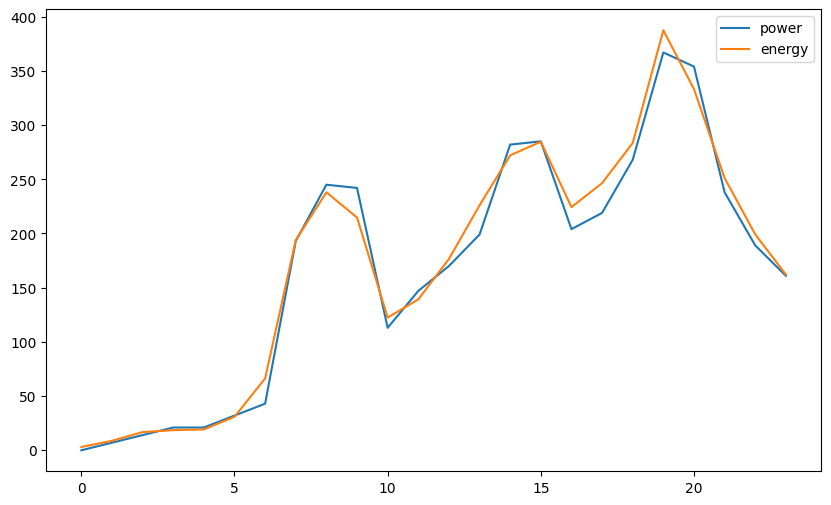

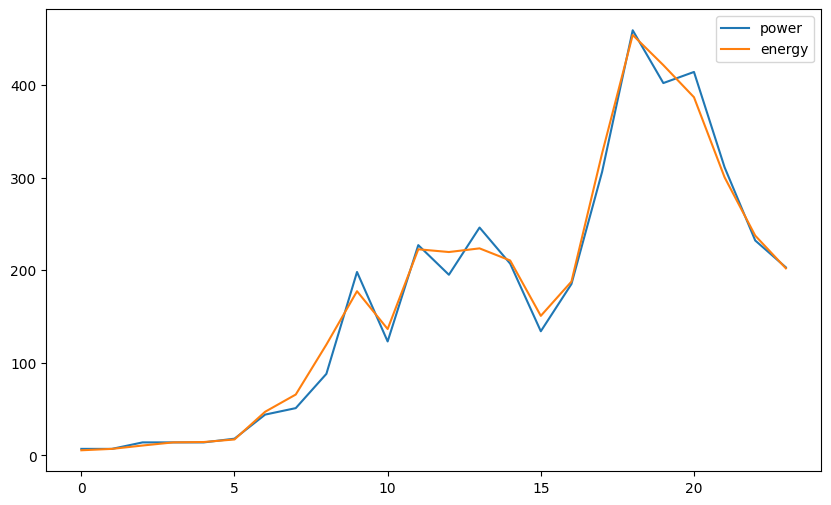

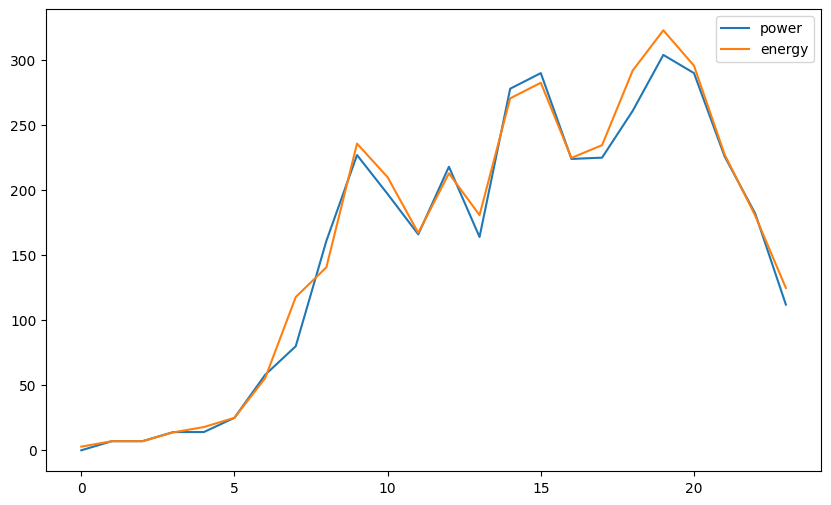

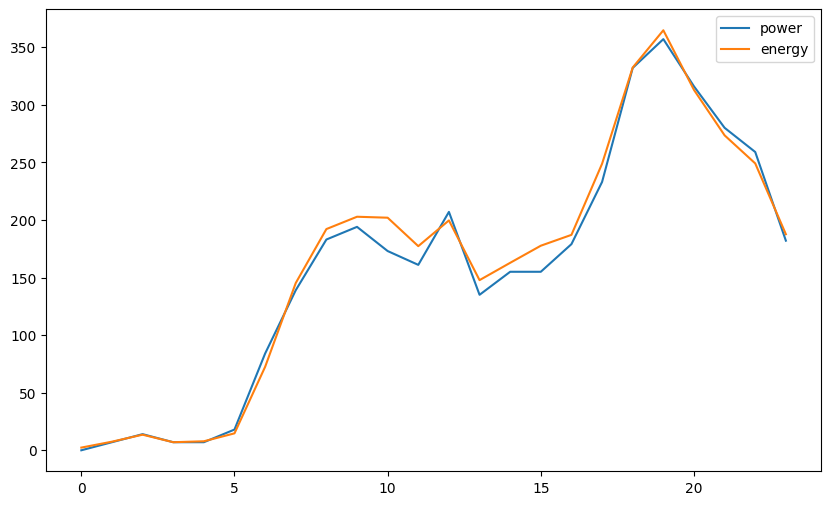

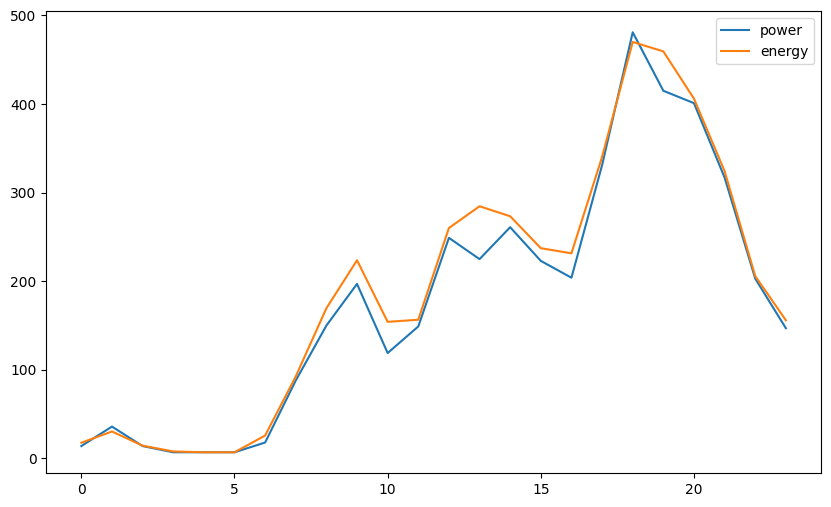

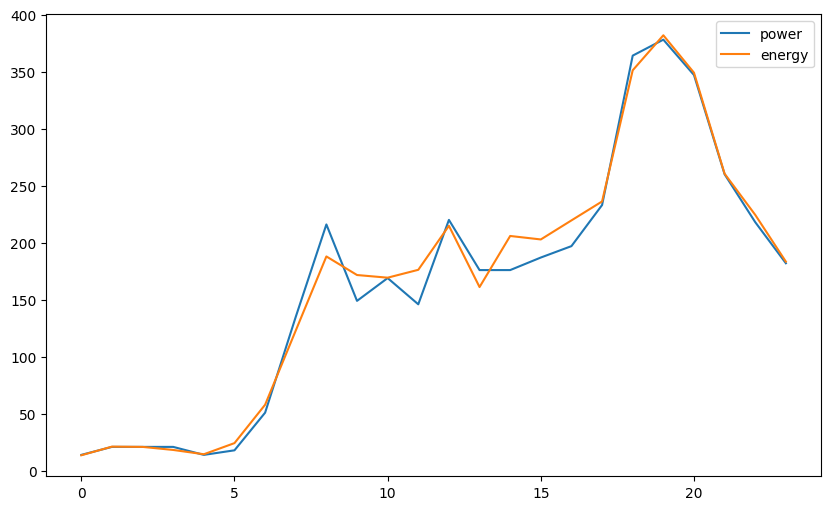

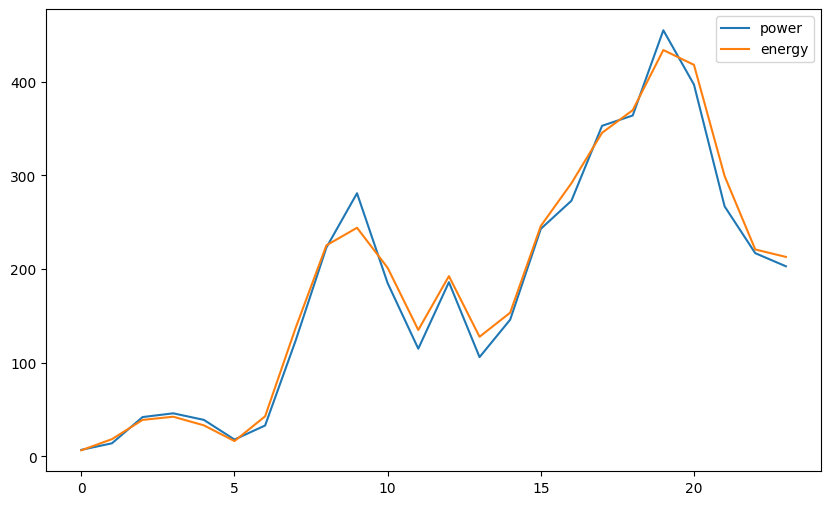

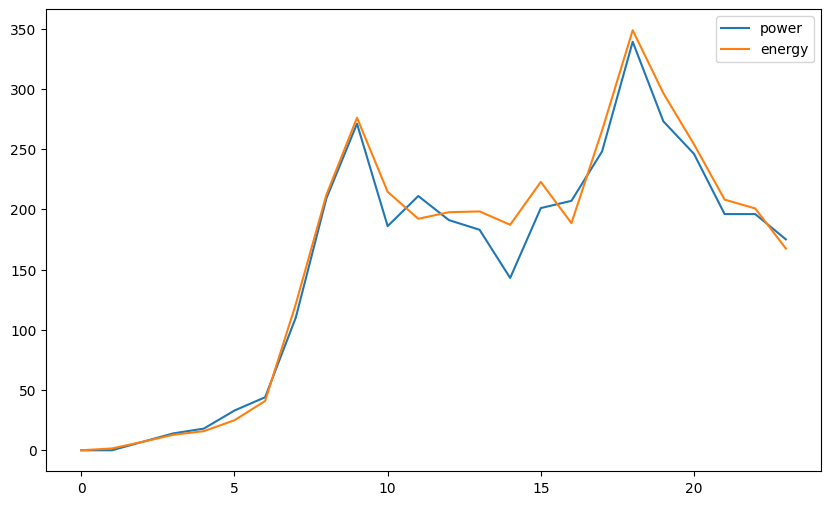

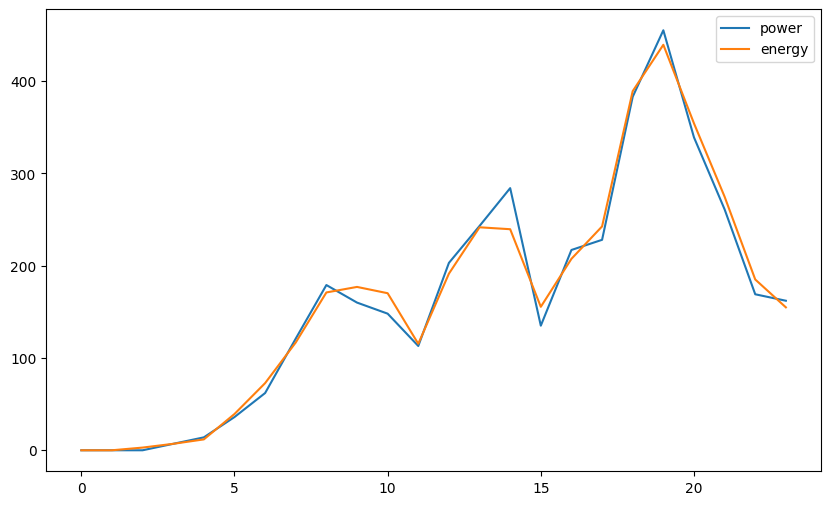

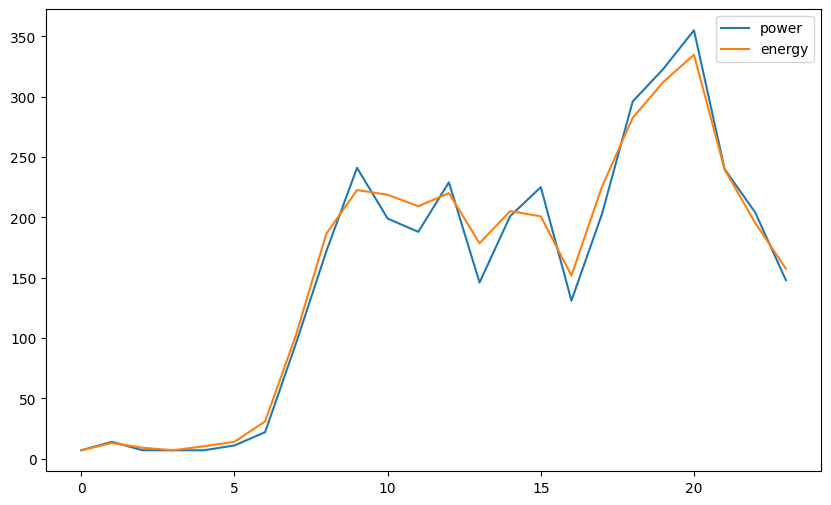

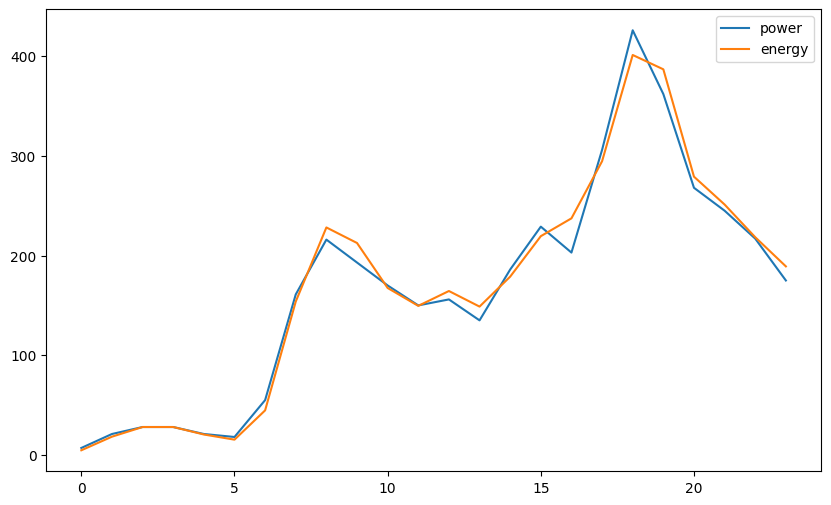

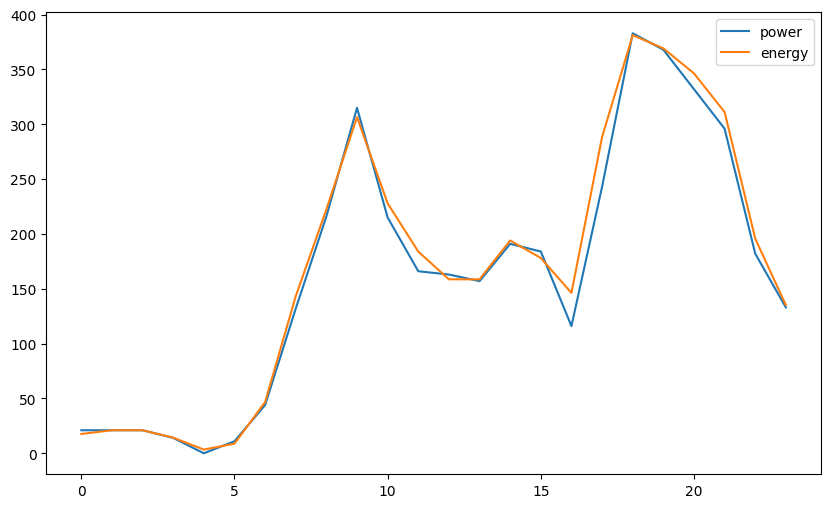

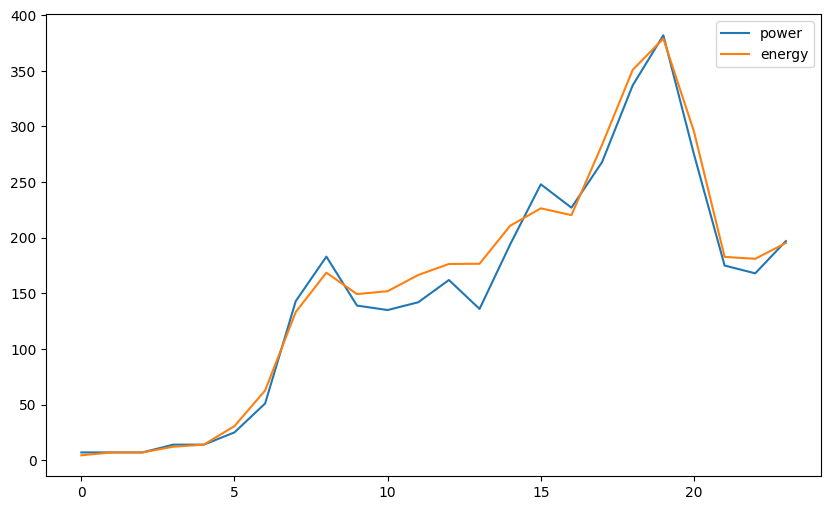

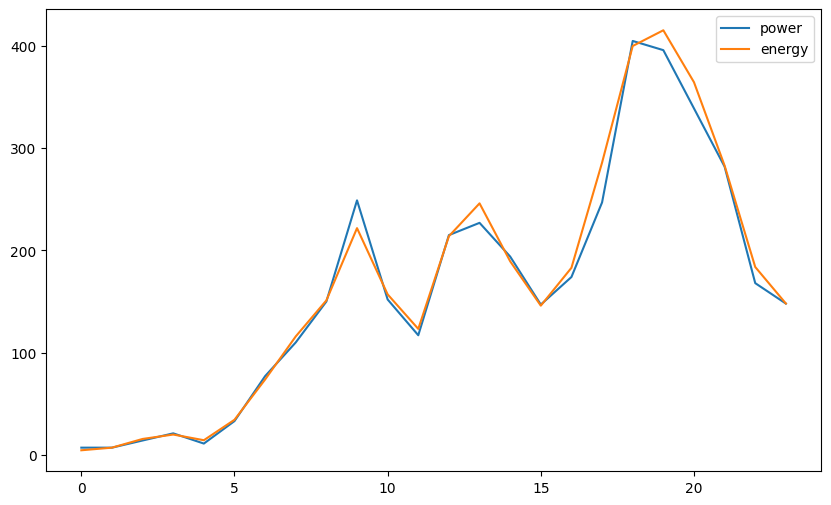

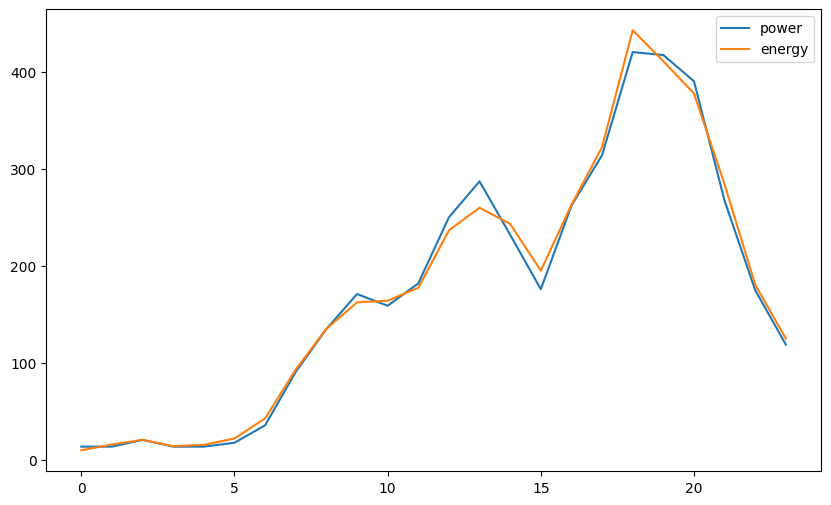

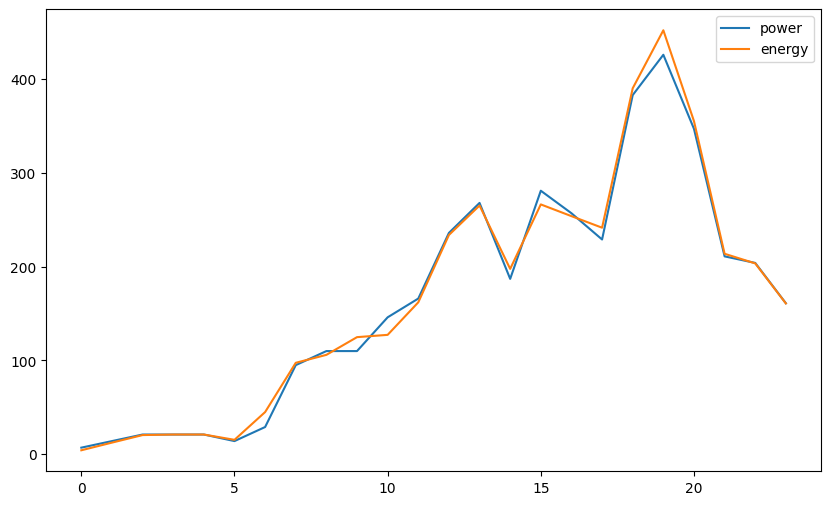

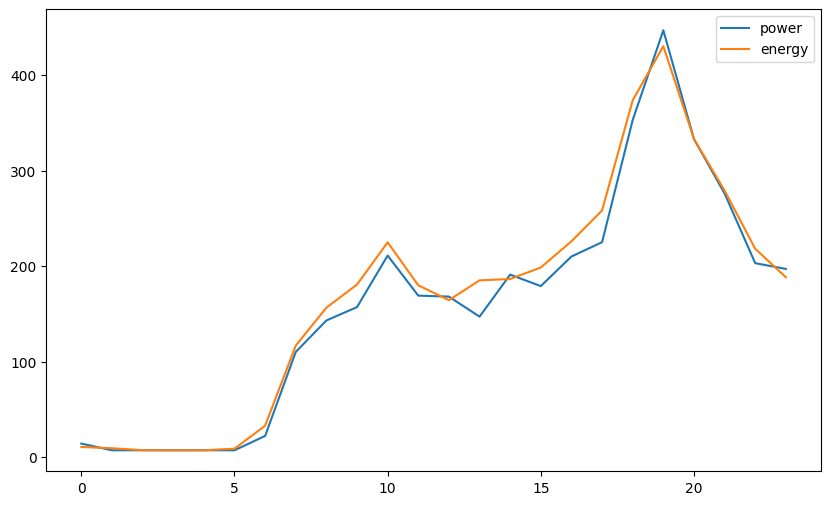

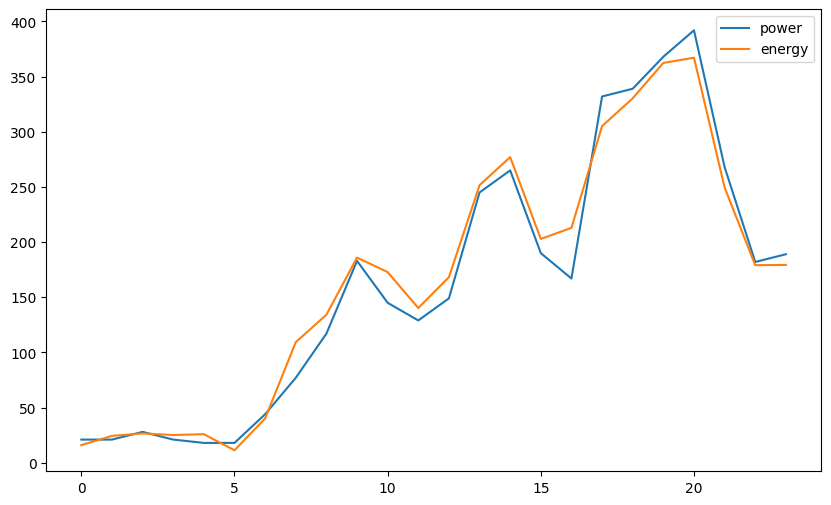

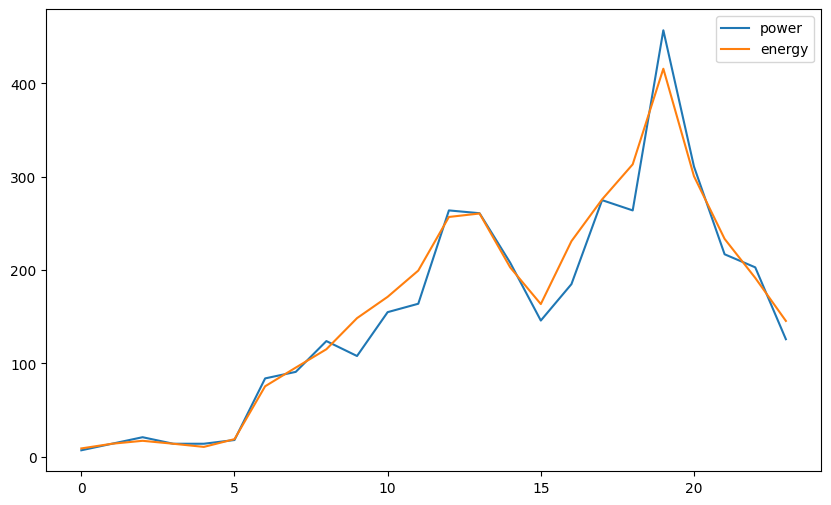

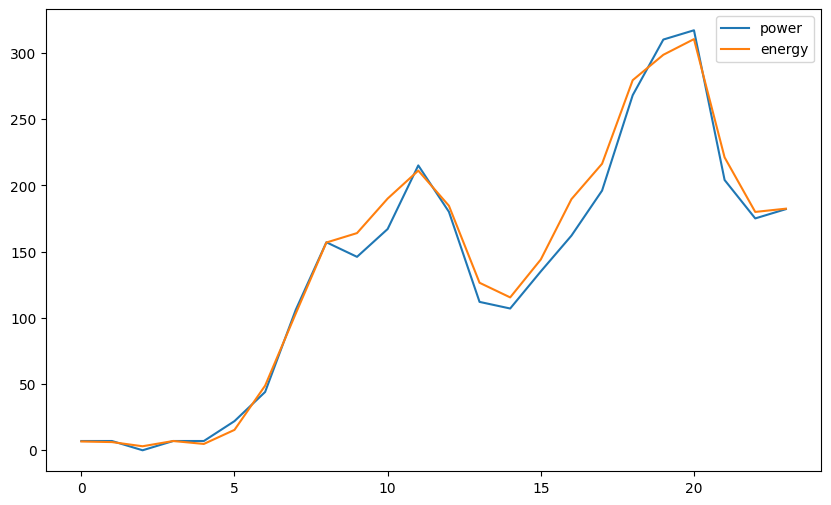

In [39]:
# Normalize the mobility aggregated charge power, calculate min, max, sum of power if there were EVs charging in the cluster then optimize this cluster's charging behavior to fit the curve
for i in range(k):
    
    cluster = clustered[clustered['cluster']==i]
    emob_agg_e = [sum(x) for x in zip(*cluster['charge_energy_list'])] # energy in kWh
    emob_agg_p = [sum(x) for x in zip(*cluster['charge_power_list'])] # power in kW
    
    emob_max_p, emob_min_p,emob_tot_p = max(emob_agg_p), min(emob_agg_p), sum(emob_agg_p)
    print("Mobility data peak power:",emob_max_p,"Mobility data minimal power:",emob_min_p,"Mobility data total power:",emob_tot_p)

    emob_max_e, emob_min_e, emob_tot_e= max(emob_agg_e), min(emob_agg_e),sum(emob_agg_e)
    print("Mobility data peak energy:",emob_max_e,"Mobility data minimal energy:",emob_min_e,"Mobility data total energy:",emob_tot_e)
    
    if emob_max_p!=0:
        emob_agg_p_norm =  [p/emob_max_p for p in emob_agg_p]
        plt.figure(figsize=(10,6))
        plt.plot(emob_agg_p,label='power')
        plt.plot(emob_agg_e,label='energy')
        plt.legend()
        plt.savefig(f'{path}/369_9_cluster_{i}_agg_p_e.png')
        cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p
        normalized_tot_e = emob_tot_e/emob_max_p
        opt_res_code = opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,date,i,path)

    else:
        index = list(cluster['event_index'])
        T = list(range(24))
        res_dict = {(e, t):0 for e in index for t in T} # Denormalize back to normal power value in kW
        # Convert the dictionary into a multi-index series to facilitate unstacking
        res = pd.Series(res_dict).unstack()
        # Save the restructured data to CSV
        res.to_csv(f'{path}/369_0_cluster_{i}.csv')
        

In [40]:
agg_e = [sum(x) for x in zip(*d['charge_energy_list'])] # energy in kWh
agg_p = [sum(x) for x in zip(*d['charge_power_list'])] # power in kW
max_p,min_p,tot_p = max(agg_p), min(agg_p), sum(agg_p)
max_e, min_e,tot_e= max(agg_e), min(agg_e),sum(agg_e)
print(tot_e)

79894.16666666669


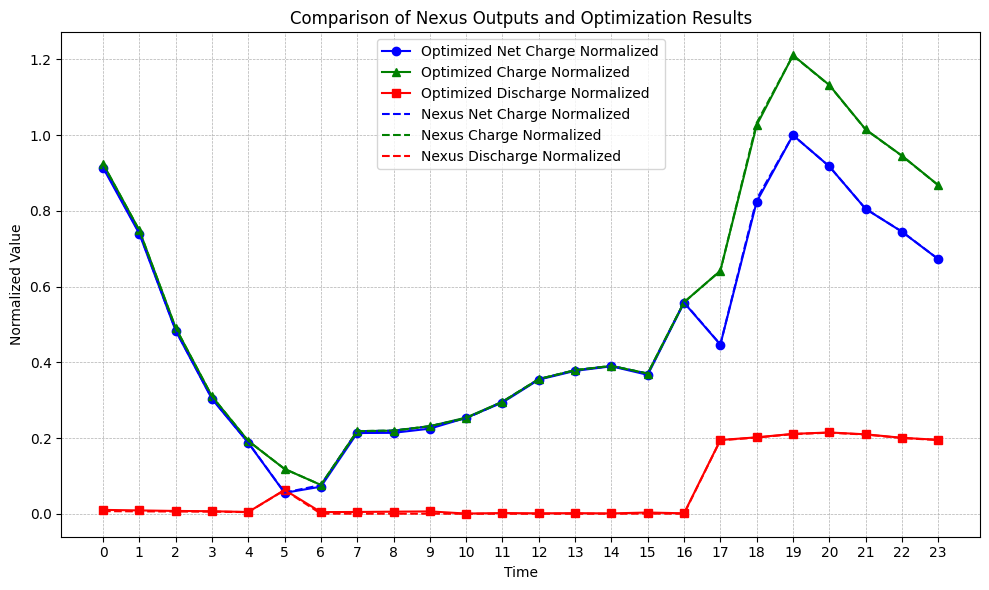

In [41]:
concat_charge = pd.DataFrame()
concat_discharge = pd.DataFrame()
for i in range(k):
    charge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_charge.csv')
    concat_charge = pd.concat([concat_charge,charge_i],axis=0)
    discharge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_discharge.csv')
    concat_discharge = pd.concat([concat_discharge,discharge_i],axis=0)
    
concat_charge = concat_charge.rename(columns={'Unnamed: 0':'event_index'})
concat_discharge = concat_discharge.rename(columns={'Unnamed: 0':'event_index'})
concat_res = concat_charge-concat_discharge
concat_res.loc[:,'event_index'] = concat_charge['event_index']
concat_res.set_index('event_index', inplace=True)

# Cast to 0 is power too low
for column in concat_res.columns:
    if column != 'event_index':
        # Apply the condition and replace values
        concat_res.loc[:, column] = concat_res[column].apply(lambda x: 0 if abs(x) < 0.01 else x)
        
concat_charge.to_csv(f'{path}/concat_charge_power_all.csv')
concat_discharge.to_csv(f'{path}/concat_dicharge_power_all.csv')
concat_res.to_csv(f'{path}/concat_net_power_all.csv')
concat_sum = concat_res.sum().sum()
concat_max = concat_res.sum().max()
plt.figure(figsize=(10, 6))

# Optimized results with solid lines and markers
plt.plot(concat_res.sum()/concat_max, label='Optimized Net Charge Normalized', color='blue', linestyle='-', marker='o')
plt.plot(concat_charge.sum()[1:]/concat_max, label='Optimized Charge Normalized', color='green', linestyle='-', marker='^')
plt.plot(concat_discharge.sum()[1:]/concat_max, label='Optimized Discharge Normalized', color='red', linestyle='-', marker='s')

# Nexus outputs with dashed lines
plt.plot(net_normalized, label='Nexus Net Charge Normalized', color='blue', linestyle='--')
plt.plot(charge['normalized_profile'], label='Nexus Charge Normalized', color='green', linestyle='--')
plt.plot(discharge['normalized_profile'], label='Nexus Discharge Normalized', color='red', linestyle='--')

plt.title('Comparison of Nexus Outputs and Optimization Results')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{path}/optimized_norm_power_vs_nexus.png')
plt.show()


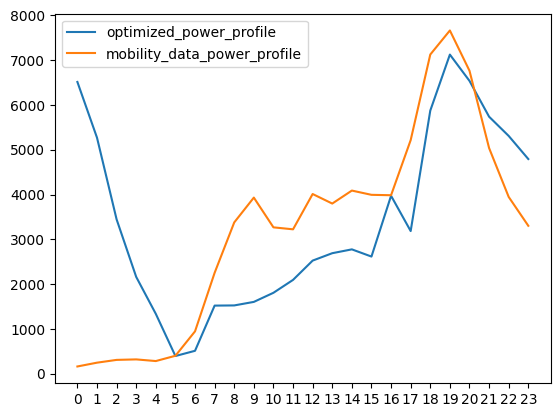

In [42]:
res_p = concat_res.sum()
plt.plot(res_p,label='optimized_power_profile')
plt.plot(agg_p, label='mobility_data_power_profile')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_power_profile.png')

In [43]:
concat_res = concat_res.sort_index()
time = pd.DataFrame(d['hourly_time_dict'].sort_index())
event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_15987/1169159873.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)


In [44]:
e = pd.DataFrame(event_e.tolist())
e.set_index(concat_res.index,inplace=True)
res_e = pd.Series(e.sum(),name='agg_e')
res_e_sum = res_e.sum()

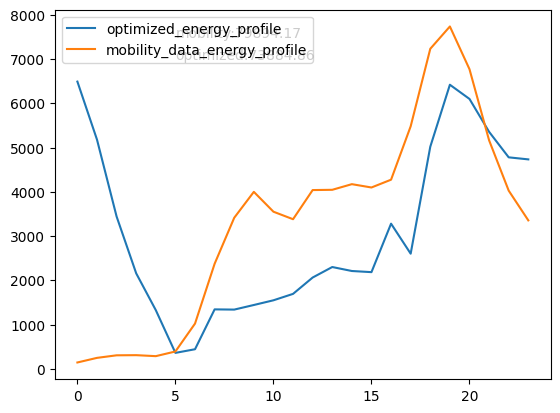

In [45]:
res_p = concat_res.sum()
# plt.plot(res_p,label='optimized_power_profile')
plt.plot(res_e,label='optimized_energy_profile')
plt.plot(agg_e,label='mobility_data_energy_profile')
plt.text(5,7500,f'mobility:{tot_e:.2f}')
plt.text(5,7000,f'optimized:{res_e_sum:.2f}')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_energy_profile.png')

In [46]:
res = pd.read_csv(f'{path}/concat_net_power_all.csv',index_col='event_index')
# for column in res.columns:
#     if column != 'event_index':
#         # Apply the condition and replace values
#         res.loc[:, column] = res[column].apply(lambda x: 0 if abs(x) < 0.1 else x)
powerlist = res.apply(lambda row: row.tolist(), axis=1)
powerlist.sort_index()

event_index
170        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
313        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
388        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
438        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
528        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                 ...                        
1098969    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099196    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099198    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099199    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099243    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Length: 32208, dtype: object

In [47]:
d.sort_index()
d.loc[:,'optimized_power_list'] = powerlist
d.loc[:,'optimized_energy_list'] = d.apply(lambda row: [row['hourly_time_dict'][x]/60 * row['optimized_power_list'][x] for x in range(24)], axis=1)
d['process_list'] = d.apply(lambda row:get_timestamp_pair(row),axis=1)
d.to_pickle(f'{path}/grid_{grid}_matched_{scenario_year}.pkl')

In [48]:
d[['event_index','arr_time','park_end_time','process_list']].loc[d['process_list'].apply(lambda x: len(x)>0)]

,event_index,arr_time,park_end_time,process_list
546,546,2050-05-06 18:10:18.000000000,2050-05-06 19:21:27.000000000,"{(2050-05-06 18:10:00, 2050-05-06 19:21:00): [..."
602,602,2050-05-06 09:38:35.000000002,2050-05-06 17:51:33.999999982,"{(2050-05-06 12:00:00, 2050-05-06 13:59:00): [..."
769,769,2050-05-06 07:23:13.000000002,2050-05-06 15:45:44.999999981,"{(2050-05-06 10:00:00, 2050-05-06 10:59:00): [..."
869,869,2050-05-06 19:17:55.000000002,2050-05-06 23:56:02.999999982,"{(2050-05-06 22:00:00, 2050-05-06 23:56:00): [..."
1013,1013,2050-05-06 16:11:03.999999998,2050-05-06 19:09:53.000000018,"{(2050-05-06 18:00:00, 2050-05-06 19:09:00): [..."
...,...,...,...,...
1098955,1098955,2050-05-05 16:52:52.000000000,2050-05-06 07:14:43.000000000,"{(2050-05-06 05:00:00, 2050-05-06 05:59:00): [..."
1098957,1098957,2050-05-06 11:52:56.999999998,2050-05-06 13:44:43.000000018,"{(2050-05-06 11:52:00, 2050-05-06 12:59:00): [..."
1098959,1098959,2050-05-06 16:52:52.000000000,2050-05-09 07:14:43.000000000,"{(2050-05-06 20:00:00, 2050-05-06 20:59:00): [..."
1099199,1099199,2050-05-06 19:44:12.000000002,2050-05-07 06:13:07.000000004,"{(2050-05-06 19:44:00, 2050-05-06 20:59:00): [..."
